# Evoked Excitatory Postsynaptic Currents (EPSCs)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Synaptic_currents" folder

In [2]:
data_folder = "data/7-Synaptic_currents"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/7-Synaptic_currents


['data/7-Synaptic_currents/2025_06_13_0008.abf',
 'data/7-Synaptic_currents/2025_06_13_0020.abf',
 'data/7-Synaptic_currents/2025_06_13_0021.abf',
 'data/7-Synaptic_currents/2025_06_13_0022_100hz.abf',
 'data/7-Synaptic_currents/2025_06_13_0019.abf',
 'data/7-Synaptic_currents/2025_06_13_0018.abf',
 'data/7-Synaptic_currents/2025_06_13_0023_100hz.abf',
 'data/7-Synaptic_currents/2025_06_13_0016.abf',
 'data/7-Synaptic_currents/2025_06_13_0017.abf',
 'data/7-Synaptic_currents/2025_06_13_0015.abf',
 'data/7-Synaptic_currents/2025_06_13_0012.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
data_file = 'data/7-Synaptic_currents/2025_06_13_0022_100hz.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_13_0022_100hz.abf')
Number of sweeps: 10
Points per sweep: 20,000
Duration per sweep: 2.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


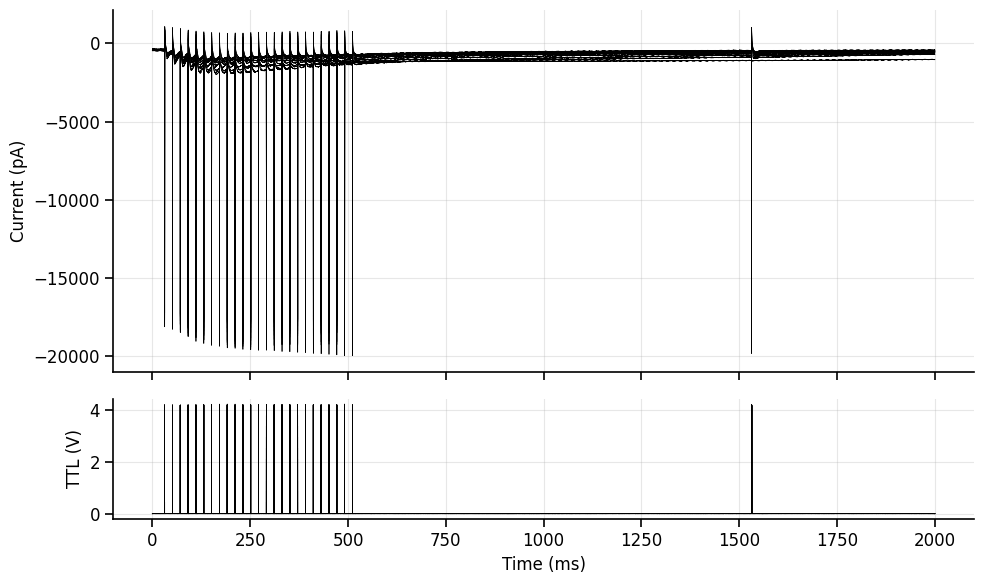

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
# The %matplotlib widget lines makes plots interactive (but sometimes is a bit buggy, doesn't always work)

# %matplotlib widget
%matplotlib inline
ax1,ax2 = traces.plot(plot_ttl=True, plot_voltage=False, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-382.0007 -465.5518 -461.7188 ... -413.9038 -381.2805 -365.4724]


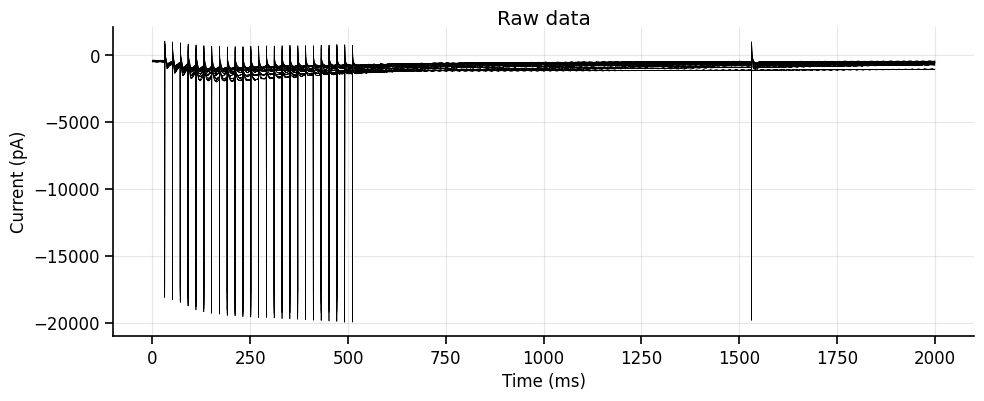

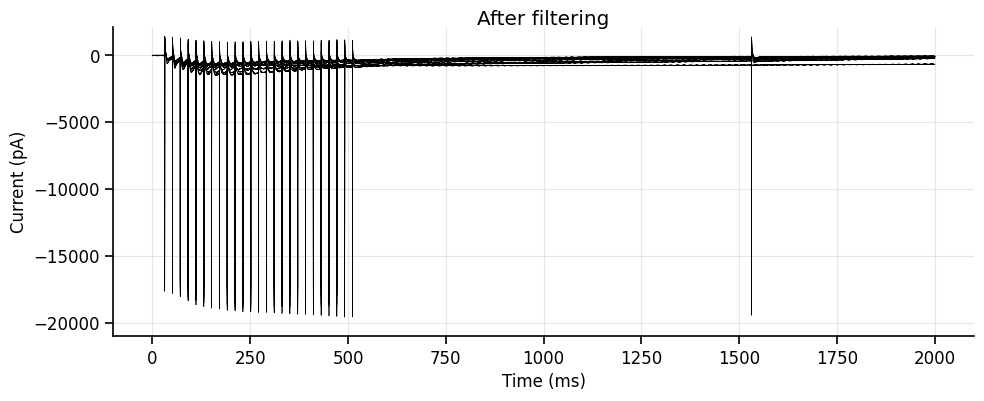

In [5]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False  # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1, apply_to_voltage=False)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 2000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = 0  # Start time for baseline subtraction
    end_baseline = 10  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    ylims = ax.get_ylim()
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering', y=0.98)
    ax.set_ylim(ylims)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [6]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure EPSC amplitudes

First we will detect all the stim stimes based on the stimulus artifacts (you will need to adjust the threshold here based on how big the artifact is in your recordings)

In [11]:
# Find positive current peaks above threshold
stim_times = traces.get_event_times(threshold=-5000, 
                                    polarity='negative', 
                                    time_units=time_units, 
                                    channel='current', sweep=0)
# traces.get_ttl_events(threshold=0.5, edge='rising', time_units='ms')
print(f"Stim times: {stim_times} ms")

Stim times: [  31.4   51.4   71.4 ...  491.4  511.4 1531.4] ms


Now we will isolate the data around each stim and measure the peak of the evoked (synaptic) current

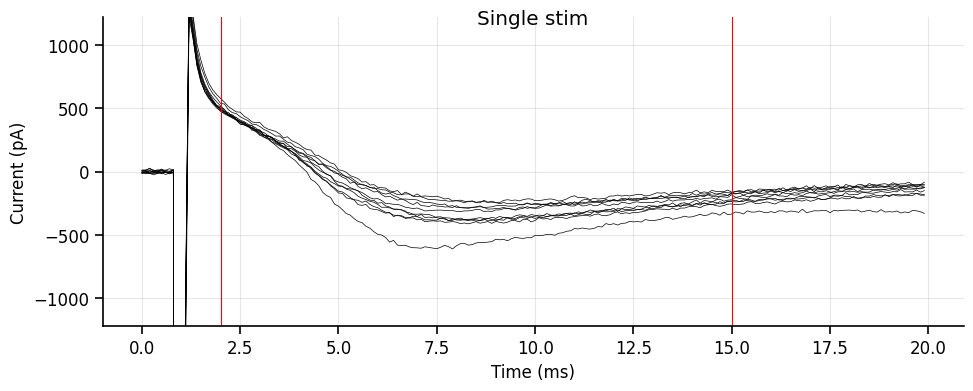

In [ ]:
marker_1 = 2  # ms
marker_2 = 15 # ms

# ---------------------------------------------------------------------------------------------------
window_size = stim_times[1] - stim_times[0]
first_stim_time = stim_times[0]
trace_crop = traces.crop(timepoint=first_stim_time-1, window=window_size, time_units=time_units)
ax = trace_crop.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
current_steps, _ = trace_crop.get_measurements(start_time=3, end_time=10, measurement_type='min', time_units=time_units)
ax.set_ylim(bottom=np.min(current_steps)*2, top=-np.min(current_steps)*2)
ax.set_title('Single stim',y=0.95)
plt.show()  

Here above you should see the EPSC traces following the first stimulus in the train. We will measure the peak current between the two markers.  

If the marker locations don't look right, you should adjust the marker times in the window above.

#### Now we can apply these parameters to measure all the EPSCs in the train.

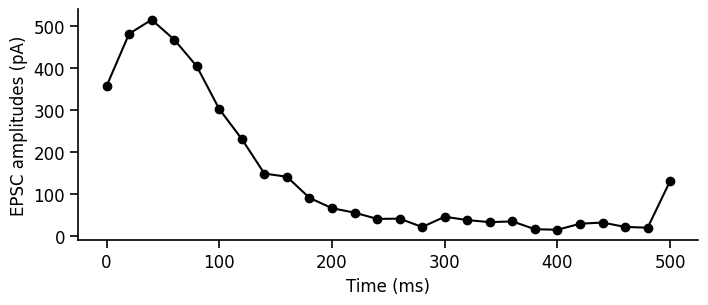

In [33]:
abs_currents = []
for i, stim_time in enumerate(stim_times):
    trace_crop = traces.crop(timepoint=stim_time-1, window=window_size, time_units=time_units)
    baseline_all_sweeps = trace_crop.current_data[:,0]
    current_all_sweeps, _ = trace_crop.get_measurements(start_time=marker_1, end_time=marker_2, measurement_type='min', time_units='ms')
    current_all_sweeps = current_all_sweeps - baseline_all_sweeps
    abs_current = np.abs(np.mean(current_all_sweeps))
    abs_currents.append(abs_current)   

delta_t = round(stim_times[1] - stim_times[0])
x = np.arange(0, delta_t*len(abs_currents), delta_t)

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(x, abs_currents, '-o', color='k')
ax.set_ylabel('EPSC amplitudes (pA)')
ax.set_xlabel(f"Time ({time_units})")
plt.show()


#### Instead of plotting the absolute size of the EPSCs, we can also perform an analysis inspired by this paper (Fig 4):
https://www.sciencedirect.com/science/article/pii/S0896627300807898

By plotting the cumulative amplitude, we can quantify the recycling rate of the synaptic vesicles, release probability, and the size of the readily releasable pool (RRP).

First let's just plot the cumulative current to get a sense of the data.

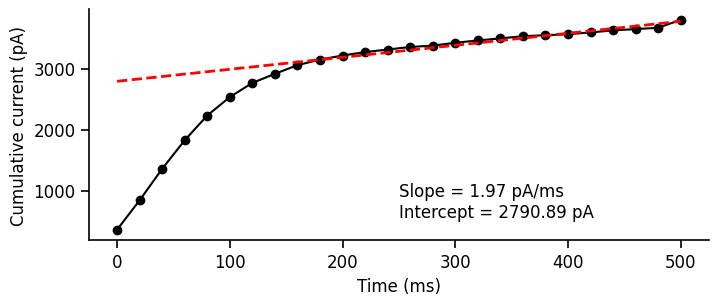

In [37]:

cumulative_current = np.cumsum(abs_currents)

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(x, cumulative_current, '-o', color='k')
ax.set_ylabel('Cumulative current (pA)')
ax.set_xlabel(f"Time ({time_units})")

# Fit a line to the points
fit_start_point = 7
from scipy.stats import linregress
x_fit = x[fit_start_point:]
current_fit = cumulative_current[fit_start_point:]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, current_fit)
fit_line = slope * x + intercept
ax.plot(x, fit_line, linestyle='--', color='r', label='Fit', linewidth=2)
ylims = ax.get_ylim()
slope_unit = f"pA/{time_units}"
ax.annotate(f"Slope = {slope:.2f} {slope_unit} \nIntercept = {intercept:.2f} pA", xy=(0.5, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

# print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}")


Now to get the final plot we can normalize the cumulative sum relative to the first EPSC

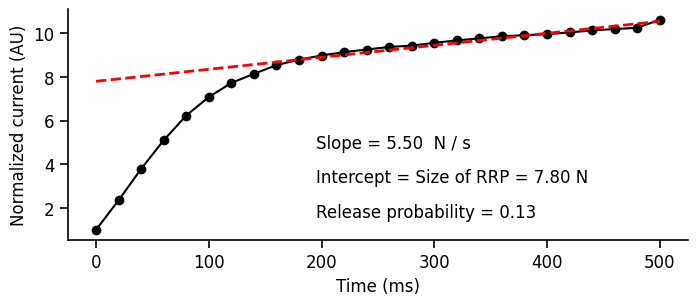

In [38]:
cumulative_current_norm = cumulative_current / cumulative_current[0]
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(x, cumulative_current_norm, '-o', color='k')
ax.set_ylabel('Normalized current (AU)')
ax.set_xlabel(f"Time ({time_units})")

# Fit a line to the points
fit_start_point = 7
from scipy.stats import linregress
x_fit = x[fit_start_point:]
current_fit = cumulative_current_norm[fit_start_point:]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, current_fit)
fit_line = slope * x + intercept
ax.plot(x, fit_line, linestyle='--', color='r', label='Fit', linewidth=2)
ylims = ax.get_ylim()
ax.annotate(f"Slope = {1000*slope:.2f}  N / s", xy=(0.4, 0.4), xycoords='axes fraction', fontsize=12)
ax.annotate(f"Intercept = Size of RRP = {intercept:.2f} N", xy=(0.4, 0.25), xycoords='axes fraction', fontsize=12)

release_probability = 1 / intercept
ax.annotate(f"Release probability = {release_probability:.2f}", xy=(0.4, 0.1), xycoords='axes fraction', fontsize=12)

plt.show()

# print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}")
